# 로지스틱 회귀 - 타이타닉 생존률 예측

## 로지스틱 회귀 수행

### 1) 패키지 준비

In [1]:
import sys
sys.path.append('../../')
import helper

import numpy as np
import seaborn as sb
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from tensorflow.keras.models import Sequential # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense      # 모델 객체에 학습층을 쌓기 위한 클래스
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### 2) 데이터셋 준비

| 변수명      | 설명                                                    |
| ----------- | ------------------------------------------------------- |
| PassengerId | 탑승객의 ID(인덱스와 같은 개념)                         |
| Survived    | 생존유무(0은 사망 1은 생존)                             |
| Pclass      | 객실의 등급                                             |
| Name        | 이름                                                    |
| Sex         | 성별                                                    |
| SibSp       | 동승한 형제 혹은 배우자의 수                            |
| Parch       | 동승한 자녀 혹은 부모의 수                              |
| Ticket      | 티켓번호                                                |
| Fare        | 요금                                                    |
| Cabin       | 선실                                                    |
| Embarked    | 탑승지 (C = Cherbourg, Q = Queenstown, S = Southampton) |

In [2]:
origin = read_excel('https://data.hossam.kr/E05/titanic.xlsx')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 3) 데이터 전처리
- 결측치 확인

In [3]:
origin.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- 결측치 정제
    - 객실번호 (Cabin) - 선실이 부여되지 않은 경우 객실 등급에 따른 차이가 있는지 여부를 확인

In [4]:
df_tmp = origin.filter(['Pclass', 'Cabin']).query('Cabin.isnull()')
df_tmp.fillna(0, inplace=True)
df_tmp.groupby('Pclass').count()

,Cabin
Pclass,
1,40
2,168
3,479


> 객실 번호는 생존 여부에 영향이 없을 것으로 판단하고 변수 자체를 제거 (열단위 제거)

In [5]:
df1 = origin.drop('Cabin', axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


- 결측치 정제
    - 탑승지 (Embarked) - 탑승지 데이터가 결측치인 경우는 2건 밖에 되지 않기 때문에 데이터 정제 과정에서 제거 (행단위)

In [6]:
df2 = df1.query('Embarked.notnull()')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


- 결측치 정제
    - 나이 (age)
        - 탑승객의 생존 여부에 중요한 영향을 미치는 요인이라고 짐작하고 삭제하지 않기로 결정
        - `연속형 데이터의 결측치를 대체`하기에 가장 적합한 값은 `중앙값 (median)`이므로 중앙값으로 대체

In [7]:
df3 = df2.copy()
df3['Age'].fillna(df3['Age'].median(), inplace=True)
df3.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

- 불필요한 필드 제거
    - 탑승객 번호 - 단순한 일련번호이므로 생존률에 영향을 주지 않는 값이라고 판단하고 이 값을 인덱스로 설정

In [8]:
df4 = df3.set_index('PassengerId')
df4.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


- 불필요한 필드 제거
    - 이름과 티켓번호 - 생존 여부에 영향을 주지 않는다고 판단하고 제거

In [9]:
df5 = df4.drop(['Name', 'Ticket'], axis=1)
df5.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


- 더미변수 처리
    - 명목형 변수는 더미변수로 변환한다

In [10]:
cda_df = get_dummies(df5, columns=['Pclass', 'Sex', 'Embarked'],
                     drop_first=True,
                     dtype='int')
cda_df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,1,0,1
2,1,38.0,1,0,71.2833,0,0,0,0,0
3,1,26.0,0,0,7.9250,0,1,0,0,1
4,1,35.0,1,0,53.1000,0,0,0,0,1
5,0,35.0,0,0,8.0500,0,1,1,0,1


### 4) 탐색적 데이터 분석
> E05의 연습문제 2번으로 진행한 바 있으므로 생략

- 기초통계량 및 산점도 추세선 확인

In [11]:
cda_df.describe()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,29.315152,0.524184,0.382452,32.096681,0.206974,0.552306,0.649044,0.086614,0.724409
std,0.486260,12.984932,1.103705,0.806761,49.697504,0.405365,0.497536,0.477538,0.281427,0.447063
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

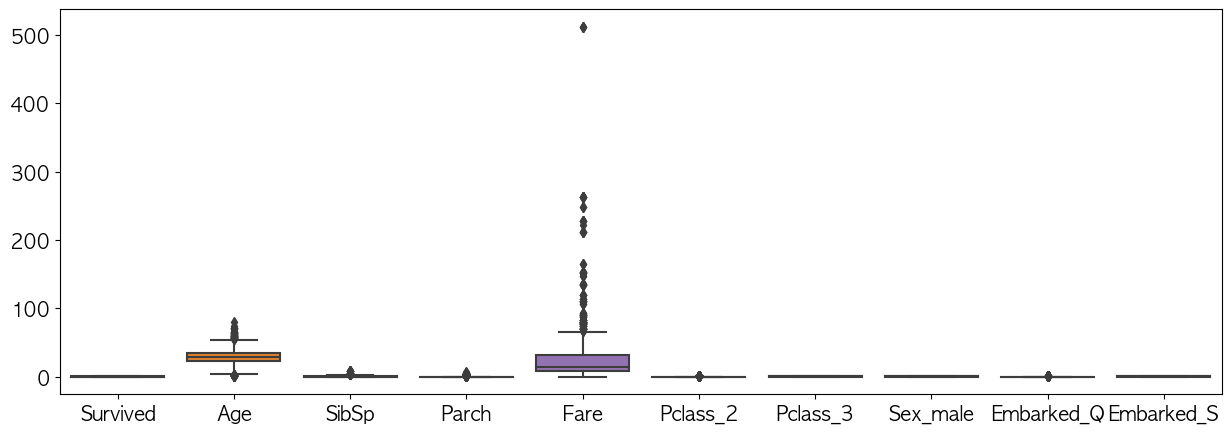

In [12]:
plt.figure(figsize=(15, 5))
sb.boxplot(data=cda_df)
plt.show()
plt.close()

### 5) 데이터셋 분할하기
- 랜덤시드 고정

In [13]:
np.random.seed(777)

- 훈련데이터(독립변수)와 레이블(종속변수) 구분하기

In [14]:
x = cda_df.drop('Survived', axis=1)
x.head()

y = cda_df[['Survived']]
y.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


- 데이터 표준화
> 일단 생략해보기로 함

- 훈련데이터와 검증데이터로 분할

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.3, 
                                                    random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((622, 9), (267, 9), (622, 1), (267, 1))

### 6) 모델 개발
- 모델 정의

In [16]:
my_model = Sequential()
my_model.add(Dense(32, activation='relu', input_shape=(9, )))
my_model.add(Dense(1, activation='sigmoid'))
my_model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 353 (1.38 KB)
Trainable params: 353 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 학습하기

In [17]:
result_fit = my_model.fit(x_train, 
                      y_train, 
                      epochs=500, 
                      validation_data=(x_test, y_test), 
                      callbacks = [EarlyStopping(monitor='val_loss',
                                                 patience=5,
                                                 verbose=1),
                                   ReduceLROnPlateau(monitor='val_loss',
                                                     patience=3,
                                                     factor=0.5,
                                                     min_lr=0.0001,
                                                     verbose=1)])

Epoch 1/500
20/20 [==============================] - 0s 5ms/step - loss: 2.1840 - acc: 0.5820 - val_loss: 1.0979 - val_acc: 0.6592 - lr: 0.0010
Epoch 2/500
20/20 [==============================] - 0s 1ms/step - loss: 1.3171 - acc: 0.6849 - val_loss: 0.9234 - val_acc: 0.6667 - lr: 0.0010
Epoch 3/500
20/20 [==============================] - 0s 1ms/step - loss: 1.0678 - acc: 0.6640 - val_loss: 0.8108 - val_acc: 0.6816 - lr: 0.0010
Epoch 4/500
20/20 [==============================] - 0s 1ms/step - loss: 0.9070 - acc: 0.6865 - val_loss: 0.7081 - val_acc: 0.6854 - lr: 0.0010
Epoch 5/500
20/20 [==============================] - 0s 1ms/step - loss: 0.7978 - acc: 0.6945 - val_loss: 0.6429 - val_acc: 0.6929 - lr: 0.0010
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.7073 - acc: 0.6945 - val_loss: 0.7001 - val_acc: 0.6404 - lr: 0.0010
Epoch 7/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6365 - acc: 0.6897 - val_loss: 0.5743 - val_acc: 0.7303 - lr:

### 7) 학습 결과 평가
- 기본적인 머신러닝 학습률 평가

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

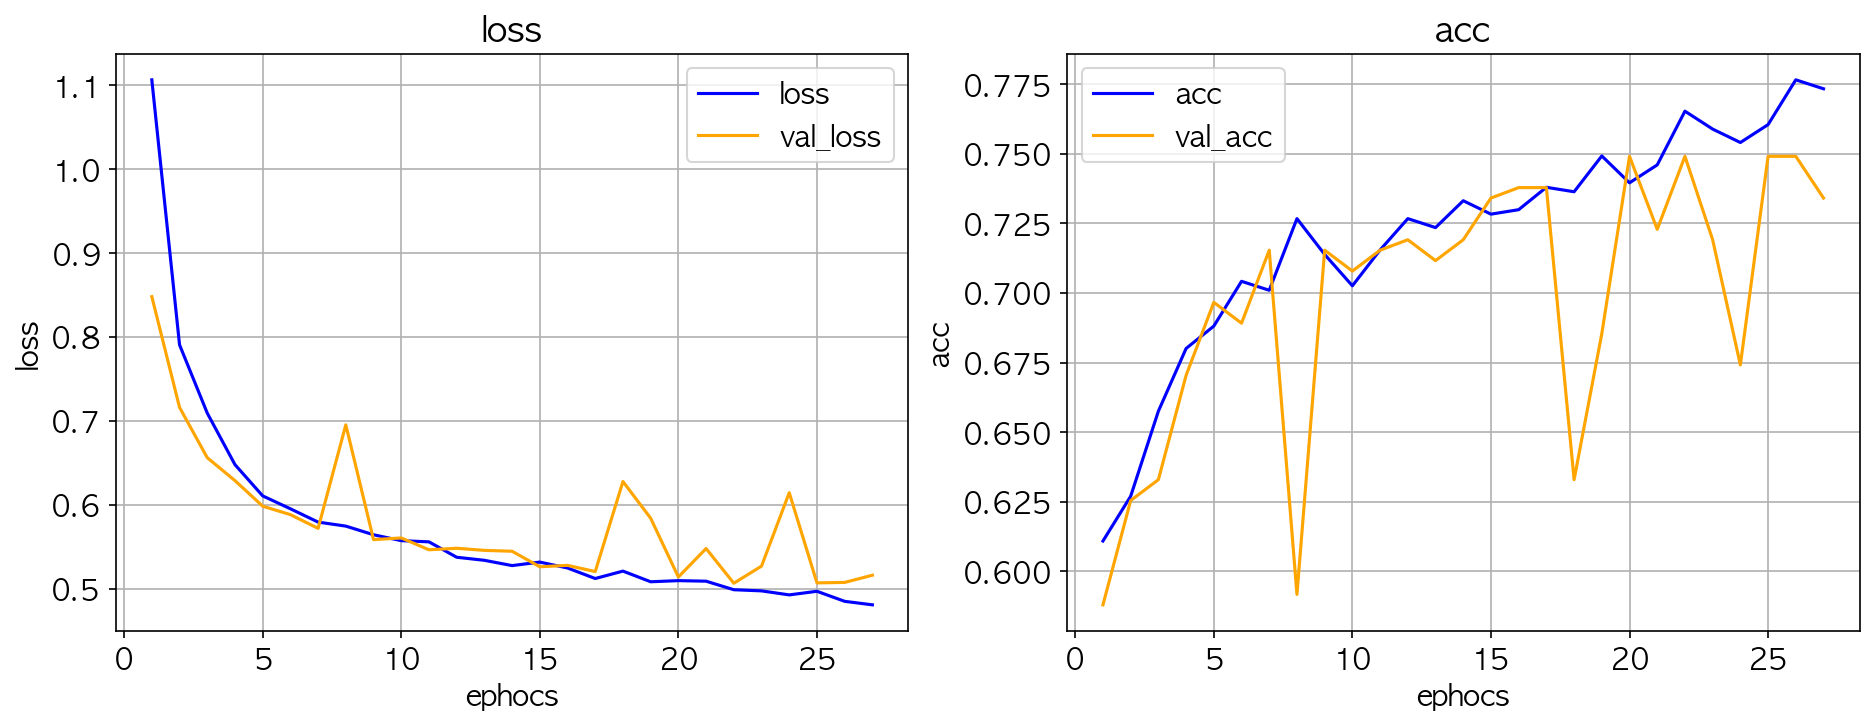

20/20 [==============================] - 0s 556us/step - loss: 0.4750 - acc: 0.7814
최종 훈련 손실률: 0.475032, 최종 훈련 정확도: 0.781350
9/9 [==============================] - 0s 469us/step - loss: 0.5159 - acc: 0.7341
최종 검증 손실률: 0.515865, 최종 검증 정확도: 0.734082


In [18]:
helper.tf_result_plot(result_fit)

evaluate1 = my_model.evaluate(x_train, y_train)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))

evaluate2 = my_model.evaluate(x_test,y_test)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

- 로지스틱 회귀 결과 검정
> helper 기능 추가

In [18]:
logit_result = helper.tf_logit_result(my_model,
                                      result_fit,
                                      x_train,
                                      y_train)

logit_result

20/20 [==============================] - 0s 361us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 353 (1.38 KB)
Trainable params: 353 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
logit_result.cmdf

,Negative,Positive
True,360,101
False,33,128


In [20]:
logit_result.odds_rate_df

array([0.7597169], dtype=float32)

In [31]:
helper.prettyPrint(logit_result.result_df.T)

+--------------------------+-----------+
|                          |         0 |
|--------------------------+-----------|
| 정확도(Accuracy)         |  0.784566 |
| 정밀도(Precision)        |  0.795031 |
| 재현율(Recall, TPR)      |  0.558952 |
| 위양성율(Fallout, FPR)   | 0.0839695 |
| 특이성(Specificity, TNR) |  0.916031 |
| RAS                      |  0.737491 |
| f1_score                 |   0.65641 |
+--------------------------+-----------+


> 직접 계산 (다윤 추가)

- 혼돈행렬 및 이진분류 평가
    - 각 항목의 의미:
        |구분|설명|
        |--|--|
        |TN(True Negative, Negative Negative)|실제는 Negative인데, Negative로 예측함.|
        |FP(False Positive, Negative Positive)|실제는 Negative인데, Positive로 예측함. (Type1 Error)|
        |FN(False Negative, Positive Negative)|실제는 Positive인데, Negative로 예측함. (Type2 Error)|
        |TP(True Positive, Positive Positive)|실제는 Positive인데, Positive로 예측함.|
- 이진분류 평가
    - scikitlearn 함수 활용 및 직접 계산
    - 정확도 -> 높을수록 좋음
    - 정밀도 -> 높을수록 좋음
    - 재현율 -> 높을수록 좋음
    - F1 score -> 높을수록 좋음
    - 위양성율 -> ***** 낮을수록 좋음
    - 특이성
- 오즈비 계산
    - 오즈비는 성공할 확률을 실패할 확률로 나눈 값이고 이 분석에서는 생존여부가 종속변수이므로 생종할 확률을 사망 확률로 나눈 값이다.
    - 오즈비(Odds Rate) 구하기
        - 계수값들만 추출하기
        - 독립변수의 `coef` : logit함수 계수. 해당 독립함수의 오즈에 $log$를 씌운 값 (자연로그)
    - $\text{Odds Rate} = \frac{생존확률}{사망확률}$
    - `계수값`에 대해 `numpy.exp()` 함수를 적용하면 각각의 회귀계수들을 오즈값으로 변환할 수 있다.
        - `odds_rate = numpy.exp(coef)`
    > 해당 독립변수가 종속변수에 미치는 영향을 더 직관적으로 확인할 수 있다.

In [36]:
# 예측값 생성
pred_bool = my_model.predict(x_train).flatten() > 0.5
pred = pred_bool.astype(int)
pred

# 혼동행렬
cm = confusion_matrix(y_train, pred)
tn, fp, fn, tp = cm.ravel()
cmdf = DataFrame([[tn, fn], [fp, tp]], 
                 index=['Actual(0)', 'Actual(1)'], 
                 columns=['Predicted(0)', 'Predicted(1)'])
cmdf

# RAS
ras = roc_auc_score(y_train, pred)
ras

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(y_train, pred)
fpr 
tpr 
# 위양성율은 또한 
# fallout = fp / (fp + tn)
# 로도 됨

# 정확도
acc = accuracy_score(y_train, pred)
acc

# 정밀도
pre = precision_score(y_train, pred)
pre

# 재현율
recall = recall_score(y_train, pred)
recall

# F1 score
f1 = f1_score(y_train, pred)
f1

# 특이성
spe = 1 - fpr
spe

# 결과표 생성
result_df = DataFrame({'정확도(Accuracy)': [acc],
                       '정밀도(Precision)': [pre],
                       '재현율(Recall, TPR)': [recall],
                       '위양성율(Fallout, FPR)': [fpr[1]],
                       '특이성(Specificity, TNR)': [spe[1]],
                       'RAS': [ras],
                       'f1_score': [f1]})
result_df

# 모델 가중치와 편향 얻기
weights, bias = my_model.layers[1].get_weights()
weights # 계수 또는 가중치
bias # 편향

# 오즈비 계산
odds_ratio = np.exp(weights)[0]
odds_ratio

result_df['오즈비'] = odds_ratio
result_df.T

 1/20 [>.............................] - ETA: 0s

20/20 [==============================] - 0s 365us/step


,0
정확도(Accuracy),0.784566
정밀도(Precision),0.795031
"재현율(Recall, TPR)",0.558952
"위양성율(Fallout, FPR)",0.083969
"특이성(Specificity, TNR)",0.916031
RAS,0.737491
f1_score,0.656410
오즈비,0.759717


### 8) 학습 결과 적용
- 실제 데이터로 예측해보기
    - 1) 예측을 위한 데이터프레임 준비

In [38]:
test_df = DataFrame({
    'dicaprio': [19, 0, 0, 0, 0, 1, 1, 0, 0],  # 영화속 남자 주인공 데이터
    'winslet': [17, 1, 2, 100, 0, 0, 0, 1, 0], # 영화속 여자 주인공 데이터
    'someone': [41, 1, 0, 50, 1, 0, 1, 0, 0]   # 임의의 데이터
}, index=['Age','SibSp','Parch','Fare','Pclass_2','Pclass_3','Sex_male','Embarked_Q','Embarked_S'])
test_df.T

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
dicaprio,19,0,0,0,0,1,1,0,0
winslet,17,1,2,100,0,0,0,1,0
someone,41,1,0,50,1,0,1,0,0


- 실제 데이터로 예측해보기
    - 2) 결과 예측하기

In [39]:
results = my_model.predict(test_df.T)
data_count, case_count = results.shape
print("%d개의 임의의 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(results)

1/1 [==============================] - 0s 26ms/step
3개의 임의의 데이터가 1개의 경우의 수를 갖는다.
[[0.09445295]
 [0.7416865 ]
 [0.5081281 ]]


In [40]:
for i,v in enumerate(results.flatten()):
    print('%s의 생존 확률은 %0.1f%% 입니다.' % (test_df.columns[i], v*100))

dicaprio의 생존 확률은 9.4% 입니다.
winslet의 생존 확률은 74.2% 입니다.
someone의 생존 확률은 50.8% 입니다.
